In [1]:
# Simple simulation of metastasis to test the assumptions of the met-score metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import sklearn.metrics as sklm
from tqdm import tqdm_notebook, tqdm
import scipy.stats as scs
import networkx as nx

from collections import defaultdict

import subprocess
import os

import seaborn as sns

from cassiopeia.TreeSolver.simulation_tools import dataset_generation as data_gen
from cassiopeia.TreeSolver.simulation_tools.simulation_utils import get_leaves_of_tree

import utilities.metastasis_sim_utils as met_sim
import utilities.metastasis_score_utils as met_utils
import utilities.compute_transition_probs as ctp

from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
from cassiopeia.TreeSolver.Node import Node

import pickle as pic

from rpy2.robjects import pandas2ri
import anndata2ri

import rpy2
import logging 

In [3]:
def compute_priors(C, S, p, mean=0.01, disp=0.1, empirical = np.array([])):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        mut_rate = p
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp 

def get_transition_stats(tree):
    
    n_transitions = 0
    transitions = defaultdict(dict)
    freqs = defaultdict(int)
    
    root = [n for n in tree if tree.in_degree(n) == 0][0]
    for e in nx.dfs_edges(tree, source=root):
        
        p,c = e[0], e[1]
        m_p, m_c = tree.nodes[p]['meta'], tree.nodes[c]['meta']
        if m_p != m_c:
            n_transitions += 1
            if m_c not in transitions[m_p]:
                transitions[m_p][m_c] = 0
            transitions[m_p][m_c] += 1
            
        if tree.out_degree(c) == 0:
            freqs[m_c] += 1
            
    return n_transitions, transitions, freqs

In [4]:
no_mut_rate = 0.985
number_of_states = 40
dropout = 0.17
depth = 15
number_of_characters = 40

pp, sp = compute_priors(number_of_characters, number_of_states, 0.025, mean=1, disp=0.1)


In [5]:
# define parameters:
N_clones = 100 #number of clones to simulate
max_mu = 0.3 #max rate of metastasis
min_alpha = 0.75 #min rate of doubling
t_range = [12,16] #range of time-steps
sigma = 6 #number of tumor samples
beta = 0.00 #extinction rate

# make samples
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
sample_list = [alphabet[i] for i in range(sigma)]

# generate color list
cmap = plt.cm.get_cmap('Blues')
cmap_list = []
for i in range(len(sample_list)):
    cmap_list.append(cmap(i/len(sample_list)))

# Simulate trees with metastsis

In [12]:
p = np.random.gamma(6, np.random.uniform(6))
y = 

9.331028079772606

In [30]:
corrs = []
for i in range(N_clones):
    if i % 10 == 0:
        print(i)
    tree, params = data_gen.generate_simulated_experiment_plasticisity(pp,
        [0.18]*number_of_characters,
        characters=number_of_characters,
        subsample_percentage=0.5,
        dropout=True, 
        sample_list = sample_list, 
        max_mu = 0.3, 
        min_alpha = min_alpha,
        depth = 11, 
        beta = 0,
        transition_matrix = tmat
        )
    
    n_mets, mets, freqs = get_transition_stats(tree.network)
    
    leaves = [n for n in tree.network if tree.network.out_degree(n) == 0]
    t = tree.network 

    meta = pd.DataFrame.from_dict(dict(zip([n.name for n in leaves], [tree.network.nodes[n]['meta'] for n in leaves])), orient='index')
    est_freqs = ctp.compute_transitions(t, meta.loc[:,0], count_unique = False)

    metsdf = pd.DataFrame.from_dict(mets, orient='index').loc[sample_list, sample_list]
    est_freqs = est_freqs.loc[sample_list, sample_list]
    
    np.fill_diagonal(est_freqs.values,0)
    # est_freqs = est_freqs.fillna(value = 0)
    #est_freqs = est_freqs / max(1, np.sum(est_freqs.values))
    est_freqs = est_freqs.apply(lambda x: x / max(1, x.sum()), axis=1)

    np.fill_diagonal(metsdf.values,0)
    # metsdf = metsdf.fillna(value = 0)
    metsdf = metsdf.apply(lambda x: x / max(1, x.sum()), axis=1)
    # metsdf = metsdf / max(1, np.sum(metsdf.values))

    corrs.append(scs.pearsonr(est_freqs.values.ravel(), metsdf.values.ravel())[0])

Generating cells at each level in tree:  73%|███████▎  | 8/11 [00:00<00:00, 21.63it/s]

0


Generating cells at each level in tree:  64%|██████▎   | 7/11 [00:00<00:00, 20.81it/s]

10


Generating cells at each level in tree:  64%|██████▎   | 7/11 [00:00<00:00, 13.58it/s]

20


Generating cells at each level in tree:  64%|██████▎   | 7/11 [00:00<00:00, 13.26it/s]

30


Generating cells at each level in tree:  64%|██████▎   | 7/11 [00:00<00:00, 16.61it/s]

40


Generating cells at each level in tree:  45%|████▌     | 5/11 [00:00<00:00, 23.68it/s]

50


Generating cells at each level in tree:  55%|█████▍    | 6/11 [00:00<00:00, 14.21it/s]

60


Generating cells at each level in tree:  64%|██████▎   | 7/11 [00:00<00:00, 12.58it/s]

70


Generating cells at each level in tree: 100%|██████████| 11/11 [00:03<00:00,  1.66it/s]


KeyError: "None of [Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')] are in the [index]"

In [31]:
corrs = [c for c in corrs if not np.isnan(c)]

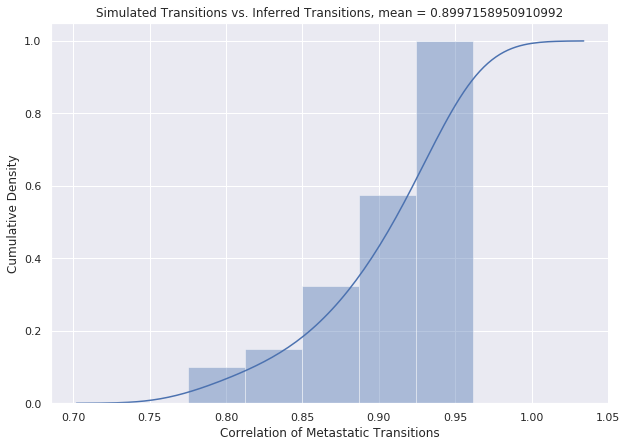

In [33]:

h = plt.figure(figsize=(10, 7))
sns.distplot(corrs, hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.xlabel("Correlation of Metastatic Transitions")
plt.ylabel("Cumulative Density")
plt.title('Simulated Transitions vs. Inferred Transitions, mean = ' + str(np.nanmean(corrs)))
plt.savefig('inferred_markov_chain.png')

In [28]:
import utilities.compute_transition_probs as ctp
tree, params = data_gen.generate_simulated_experiment_plasticisity(pp,
        [0.18]*number_of_characters,
        characters=number_of_characters,
        subsample_percentage=0.5,
        dropout=True, 
        sample_list = sample_list, 
        max_mu = 0.3, 
        min_alpha = min_alpha,
        depth = 11, 
        beta = 0,
        )
    
n_mets, mets, freqs = get_transition_stats(tree.network)

leaves = [n for n in tree.network if tree.network.out_degree(n) == 0]
t = tree.network 

meta = pd.DataFrame.from_dict(dict(zip([n.name for n in leaves], [tree.network.nodes[n]['meta'] for n in leaves])), orient='index')
est_freqs = ctp.compute_transitions(t, meta.loc[:,0], count_unique = False)

metsdf = pd.DataFrame.from_dict(mets, orient='index').loc[sample_list, sample_list]
est_freqs = est_freqs.loc[sample_list, sample_list]

np.fill_diagonal(est_freqs.values,0)
est_freqs = est_freqs.fillna(value = 0)
est_freqs = est_freqs / max(1, np.sum(est_freqs.values))
# est_freqs = est_freqs.apply(lambda x: x / max(1, x.sum()), axis=1)

np.fill_diagonal(metsdf.values,0)
metsdf = metsdf.fillna(value = 0)
# metsdf = metsdf.apply(lambda x: x / max(1, x.sum()), axis=1)
metsdf = metsdf.loc[sample_list, sample_list]
metsdf = metsdf / max(1, np.sum(metsdf.values))


Generating cells at each level in tree: 100%|██████████| 11/11 [00:03<00:00,  1.37it/s]


(1.0, 0.0)


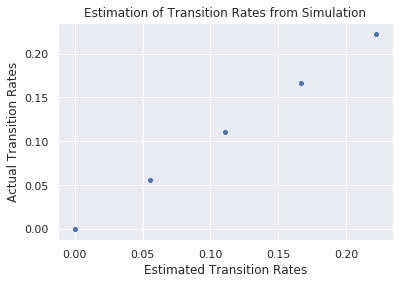

In [29]:
print(scs.pearsonr(est_freqs.values.ravel(), metsdf.values.ravel()))
sns.scatterplot(est_freqs.values.ravel(), metsdf.values.ravel())
plt.xlabel("Estimated Transition Rates")
plt.ylabel("Actual Transition Rates")
plt.title("Estimation of Transition Rates from Simulation")
plt.show()

In [172]:
columner1 = ['mu', 'alpha', 'N', 'n_mets', 'NN_met', 'DynMet']
columner2 = [sample_list[i] for i in range(len(sample_list))]
masterDF = pd.DataFrame(columns=columner1+columner2)

for i in range(N_clones):
    if i % 10 == 0:
        print(i)
        
    pp, sp = compute_priors(number_of_characters, number_of_states, 0.05, mean=1, disp=0.1)

    tree, params = data_gen.generate_simulated_experiment_plasticisity(pp,
        [0.18]*number_of_characters,
        characters=number_of_characters,
        subsample_percentage=0.5,
        dropout=True, 
        sample_list = sample_list, 
        max_mu = max_mu, 
        min_alpha = min_alpha,
        depth = 14, 
        beta = 0,
        )
    
    n_mets, mets, freqs = get_transition_stats(tree.network)
    
    leaves = [n for n in tree.network if tree.network.out_degree(n) == 0]
    meta = pd.DataFrame.from_dict(dict(zip([l.name for l in leaves], [tree.network.nodes[l]['meta'] for l in leaves])), orient='index', columns = ['sample'])
    nn_met = met_utils.compute_NN_metastasis_score(tree.network, meta['sample'], _method = 'allele', verbose=False)
    norm_fitch = met_utils.compute_dynamic_metastasis_score(tree.network, meta['sample'])
    
    masterDF.loc[i, 'mu'] = params['mu']
    masterDF.loc[i, 'alpha'] = params['alpha']
    masterDF.loc[i, 'N'] = params['N']
    masterDF.loc[i, 'n_mets'] = n_mets
    masterDF.loc[i, 'NN_met'] = nn_met
    masterDF.loc[i, 'DynMet'] = norm_fitch
    
    for k in freqs:
        masterDF.loc[i, k] = freqs[k]

Generating cells at each level in tree:  57%|█████▋    | 8/14 [00:00<00:00, 20.61it/s]

0


Creating pairs to compare: 100%|██████████| 12136/12136 [01:35<00:00, 126.63it/s] 


KeyboardInterrupt: 

In [34]:
## read in previous met sim results
masterDF = pd.read_csv("met_sim_df.txt", sep='\t', index_col = 0)
# masterDF['MutRate'] = 0
# print(masterDF.tail(5))
# masterDF.loc[range(100), 'MutRate'] = 0.01
# masterDF.loc[range(100, 200), 'MutRate'] = 0.02
# masterDF.loc[range(200, 300), 'MutRate'] = 0.03
# masterDF.loc[range(300, 400), 'MutRate'] = 0.04
# masterDF.loc[range(400, 500), 'MutRate'] = 0.05
# masterDF.loc[range(500, 600), 'MutRate'] = 0.1
# masterDF.loc[range(600, 700), 'MutRate'] = 0.15

In [41]:
# masterDF.to_csv("met_sim_df.mutrate.txt", sep='\t')

In [35]:
masterDF.fillna(0, inplace=True)
masterDF['Norm_mets'] = masterDF['n_mets'].div(masterDF['N'])

masterDF.head(5)

,mu,alpha,N,n_mets,NN_met,DynMet,A,B,C,D,E,F,Norm_mets
0,0.277662,0.841051,5332,2968,0.703989,0.221159,808,897,935,908.0,888,896,0.556639
1,0.238290,0.990001,15773,7553,0.653602,0.196170,3080,2528,2631,2586.0,2464,2484,0.478856
2,0.082923,0.752288,1970,334,0.350948,0.081260,145,157,127,824.0,551,166,0.169543
3,0.033863,0.804895,4067,283,0.183978,0.034555,107,172,173,3246.0,160,209,0.069584
4,0.257002,0.799269,5607,2895,0.671110,0.209864,918,906,806,1009.0,924,1044,0.516319


In [77]:
# make a masterDF of results
# masterDF = met_sim.simulate_counts(sample_list, N_clones, max_mu, min_alpha, t_range, beta)

In [78]:
# Subplot distribution of UMI per cell per sample
f, axarr = plt.subplots(10, 10, figsize=(15,15))

for j in range(0,100):
    x = int((j)/10)
    y = int((j)%10)
    
    cellspersample = masterDF.iloc[j][sample_list].tolist()
    axarr[x,y].pie(cellspersample, colors=cmap_list, startangle=90, counterclock=False, wedgeprops=dict(width=0.5))
    axarr[x,y].text(0, 0, "µ="+"%.2f" % masterDF.iloc[j]['mu'] +"\nN="+str(masterDF.iloc[j]['N']), ha='center', va='center')
    axarr[x,y].axis('equal')
       
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f285a7ad1e0> (for post_execute):


KeyboardInterrupt: 

In [36]:

# find background distribution across all clones
background = masterDF.filter(sample_list, axis=1).sum(axis=0)
masterDF['CV'] = 0
cramers_list = []
for k in tqdm_notebook(range(0, masterDF.shape[0])):
    
    query = masterDF.iloc[k][sample_list]

    query = pd.DataFrame(query)

    table = pd.concat([background, query], axis=1)
    table.fillna(value = 0, inplace=True)
    table.columns = ["Background", "LG"]
    table["Background"] = table["Background"] - table["LG"]

    
    table = met_utils.scale_counts(table)
    stat = scs.chi2_contingency(table)[0]
    v = met_utils.cramers_v(stat, np.sum(table.sum()), table.shape[0], table.shape[1])
    cramers_list.append(1-v)
    
    masterDF.loc[k, 'CV'] = (1-v)
    
#     v = cramers_v(stat, np.sum(table.sum()), table.shape[0], table.shape[1])
    
#     # First, make an expanded list of the observed samples
#     obs = masterDF.iloc[k][sample_list]
#     obs_exp = []
#     for i in range(len(obs)):
#         for j in range(int(obs[i])):
#             obs_exp.append(sample_list[i])
            
#     # Next, make an expanded list of the expected samples (of the same dimension as the observed!?)  
#     pred_exp = []
#     progress = 0
#     for i in range(len(obs)):
#         progress += pred_norm[i]
#         while float(len(pred_exp))/len(obs_exp) < progress:
#             pred_exp.append(sample_list[i])
    
#     # make confusion matrix of predicted vs observed
#     confusion_matrix = sklm.confusion_matrix(obs_exp, pred_exp, labels=sample_list)
    
#     # calculate Cramers V and update
#     cramersV1 = cramers_corrected_stat(confusion_matrix)
#     #cramersV2 = cramers_stat(confusion_matrix)
#     cramers_list.append(cramersV1)

In [80]:
masterDF = masterDF[masterDF['mu'] <= 0.3]

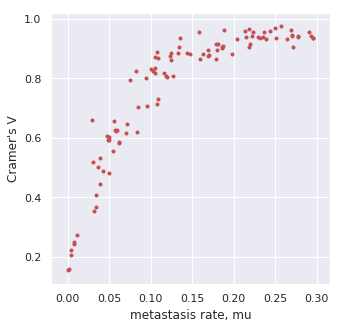

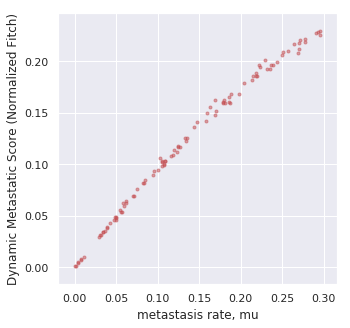

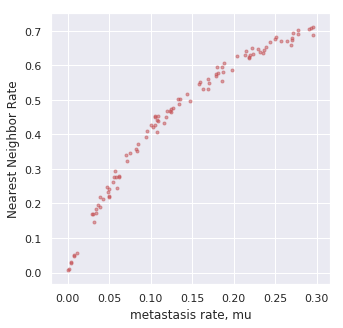

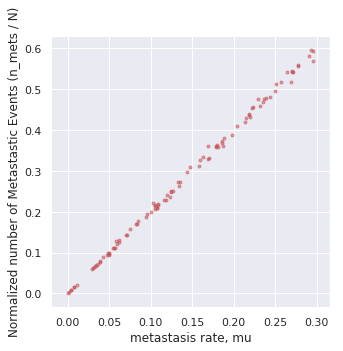

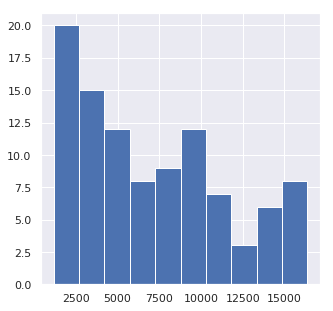

In [37]:
# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['CV'], color='r', marker='.')
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel("Cramer's V")
plt.savefig('sim_mu_vs_cv.png')
plt.show()

# plot distribution
h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['DynMet'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Dynamic Metastatic Score (Normalized Fitch)')
plt.savefig('sim_mu_vs_dynmet.png')
plt.show()

h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['NN_met'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Nearest Neighbor Rate')
plt.savefig('sim_mu_vs_nn.png')
plt.show()

h = plt.figure(1,figsize=(5,5))
scat = plt.scatter(masterDF['mu'], masterDF['Norm_mets'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('metastasis rate, mu')
ylab = plt.ylabel('Normalized number of Metastastic Events (n_mets / N)')
plt.savefig('sim_mu_vs_nmets.png')
plt.show()

h = plt.figure(1, figsize=(5,5))
hist = plt.hist(masterDF['N'])
plt.show()

# sns.scatterplot('mu', 'NN_met', data=masterDF, hue='MutRate')
# plt.show()

# sns.scatterplot('mu', 'DynMet', data=masterDF, hue='MutRate')
# plt.show()

# sns.scatterplot('CV', 'mu', data=masterDF, hue='MutRate')
# plt.show()

# plt.savefig('sim_metcounts_vs_rate.png')

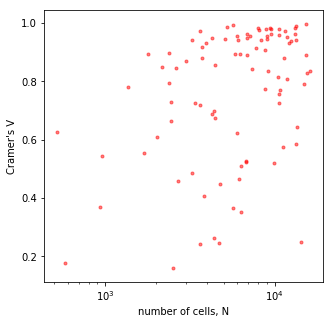

In [30]:
# plot correlation between number of cells and Cramers V
h2 = plt.figure(2,figsize=(5,5))
scat = plt.scatter(masterDF['N'], masterDF['CV'], color='r', marker='.', alpha=0.5)
xlab = plt.xlabel('number of cells, N')
ylab = plt.ylabel("Cramer's V")
xsca = plt.xscale("log")

## Simulate on an existing tree

In [82]:
def overlay_markov_chain(tree,
    sample_list = ['A'], # set of possible labels for each cell
    max_mu = 0.3, # maximum rate of change
):
        
    mu = max_mu*np.random.random()
    
    root = [n for n in tree if tree.in_degree(n) == 0][0]
    
    # pre-process tree such that only leaves are 
    max_depth = max(nx.shortest_path_length(tree, root, node) for node in tree.nodes())
    shortest_paths = nx.shortest_path_length(tree, root)
    
    _leaves = [n for n in tree if tree.out_degree(n) == 0]
    for l in _leaves:

        if shortest_paths[l] < max_depth:
            
            n = l
            while tree.out_degree(n) < 1:
                parent = list(tree.predecessors(n))[0]
                tree.remove_node(n)
                n = parent
                    
    n_transitions = 0
    
    tree.node[root]["meta"] = np.random.choice(sample_list)
    
    for e in nx.dfs_edges(tree, source=root):
        
        if np.random.random() < mu:
            
            temp_sample_list = sample_list.copy()
            temp_sample_list.remove(tree.node[e[0]]['meta'])
            trans = np.random.choice(temp_sample_list)
            tree.node[e[1]]['meta'] = trans
            
            n_transitions += 1
        else:
            tree.node[e[1]]['meta'] = tree.node[e[0]]['meta']
            
    
    # relabel nodes
    rndict = {}
    for n in tree.nodes:
        rndict[n] = Node(n.name, n.get_character_vec())
    tree = nx.relabel_nodes(tree, rndict)
    
    params = {'mu': mu, 
            'N': len([n for n in tree if tree.out_degree(n) == 0])
    }

    tree = Cassiopeia_Tree("simulated", network=tree)
    return tree, params
    
    

### Look at bootstrap results

In [39]:
def network_to_cm(G):
    
    targets = get_leaves_of_tree(G)
    
    char_vecs = []
    names = []
    for t in targets:
        char_vecs.append(t.get_character_vec())
        names.append(t.name)
    
    M = len(char_vecs[0])
    cm = pd.DataFrame(char_vecs, columns = ['r' + str(i) for i in range(M)])
    cm.index = names
    
    return cm

nfitch = defaultdict(dict)
mus = defaultdict(dict)
nns = []

true_net_dir = "/data/yosef2/users/mattjones/projects/scLineages/true_networks/400_samples/characters/trees/"
_recons_dir = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/bootstrap/ilp/"
_cm_dir = "/data/yosef2/users/mattjones/projects/scLineages/stress_tests/400_samples/bootstrap/cms/"

# iterate over simulated trees 
for rep in tqdm(range(1)):
    
    # draw markov chains
    for i in tqdm(range(10)):

        recons_dir = _recons_dir + "cm" + str(rep+1) + "/"
        cm_dir = _cm_dir + "cm" + str(rep+1) + "/"
        
        sim_tree = pic.load(open(true_net_dir + "true_network_characters_40_run_" + str(rep) + ".pkl", 'rb'))

        sim_tree_met, params = overlay_markov_chain(sim_tree, sample_list, max_mu = 0.3)

         #cm = network_to_cm(sim_tree_met.network)
            
        for b in tqdm(range(50)):
            
            cm = pd.read_csv(cm_dir + "bootstrap_" + str(b) + "_cm.txt", sep='\t', index_col = 0)
            
            reconstructed_tree = pic.load(open(recons_dir + "ilp_tree_cm" + str(rep+1) + "_" + str(b) + ".pkl", 'rb'))

            n_mets, mets, freqs = get_transition_stats(sim_tree_met.network)

            leaves = [n for n in sim_tree_met.network if sim_tree_met.network.out_degree(n) == 0]
            meta = pd.DataFrame.from_dict(dict(zip([l.name for l in leaves], [sim_tree_met.network.nodes[l]['meta'] for l in leaves])), orient='index', columns = ['sample'])

            # append meta to reconstructed tree
            # reconstructed_tree = Cassiopeia_Tree('simulated', network = reconstructed_tree).post_process(cm).network
            reconstructed_tree = reconstructed_tree.post_process(cm).network
            
            # nn_met = met_utils.compute_NN_metastasis_score(reconstructed_tree, meta['sample'], _method = 'allele', verbose=False)
            norm_fitch = met_utils.compute_dynamic_metastasis_score(reconstructed_tree, meta['sample'])
            
            if i not in nfitch[rep]:
                nfitch[rep][i] = []
                mus[rep][i] = []
                
            nfitch[rep][i].append(norm_fitch)
            mus[rep][i].append(params['mu'])
            # nns.append(nn_met)




  0%|          | 0/1 [00:00<?, ?it/s]



  0%|          | 0/10 [00:00<?, ?it/s]




  0%|          | 0/50 [00:00<?, ?it/s]




  2%|▏         | 1/50 [00:01<01:19,  1.63s/it]




  4%|▍         | 2/50 [00:02<01:13,  1.52s/it]




  6%|▌         | 3/50 [00:04<01:07,  1.44s/it]




  8%|▊         | 4/50 [00:05<01:04,  1.39s/it]




 10%|█         | 5/50 [00:06<01:03,  1.40s/it]




 12%|█▏        | 6/50 [00:08<00:59,  1.36s/it]




 14%|█▍        | 7/50 [00:09<00:57,  1.34s/it]




 16%|█▌        | 8/50 [00:10<00:55,  1.32s/it]




 18%|█▊        | 9/50 [00:11<00:52,  1.27s/it]




 20%|██        | 10/50 [00:13<00:52,  1.30s/it]




 22%|██▏       | 11/50 [00:14<00:50,  1.30s/it]




 24%|██▍       | 12/50 [00:15<00:47,  1.26s/it]




 26%|██▌       | 13/50 [00:16<00:47,  1.27s/it]




 28%|██▊       | 14/50 [00:18<00:45,  1.27s/it]




 30%|███       | 15/50 [00:19<00:45,  1.30s/it]




 32%|███▏      | 16/50 [00:20<00:43,  1.28s/it]




 34%|███▍      | 17/50 [00:22<00:42,  1.28s/it]

In [48]:
# convert nested dictionary to dataframe 
boot_df = pd.DataFrame(columns=['rep', 'mu', 'boot', 'nfitch'])
j = 0
for rep in nfitch.keys():
    for i in nfitch[rep].keys():
        
        
        nfitches = nfitch[rep][i]
        mu_set = mus[rep][i]
        for b in range(len(nfitch[rep][i])):
            boot_df.loc[j, 'rep'] = rep
            boot_df.loc[j, 'mu'] = mu_set[b]
            boot_df.loc[j, 'boot'] = b
            boot_df.loc[j, 'nfitch'] = nfitches[b]
        
            j += 1

boot_df.head(5)

,rep,mu,boot,nfitch
0,0,0.0907902,0,0.100356
1,0,0.0907902,1,0.105784
2,0,0.0907902,2,0.117871
3,0,0.0907902,3,0.108984
4,0,0.0907902,4,0.108397


In [74]:
boot_df.to_csv('test_boot_df.txt', sep='\t')

In [72]:
sns.relplot(x='mu', y='nfitch', hue='rep', data=boot_df)

AttributeError: 'int' object has no attribute 'view'

In [31]:

sns.scatterplot(mus, nfitch)
plt.xlabel('Mu')
plt.ylabel('Normalized Fitch')
plt.show()

sns.scatterplot(mus, nns)
plt.xlabel('Mu')
plt.ylabel('NN Score')
plt.show()

sns.scatterplot(nfitch, nns)
plt.xlabel('Normalized Fitch')
plt.ylabel('NN Score')
plt.show()

TypeError: len() of unsized object